In [ ]:
!pip install python-igraph
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install easygui
!pip install cairocffi
!pip install PyDrive
!pip install stellargraph
!pip install networkx
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 14.8 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=18fef3668d9a8c38023453f035e2b512b45f13a7c0ddd2d788655fb3d341f216
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 713 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pub

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1tE2mJUoGpakAIDgxWtQNOZKb_d4slsj9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('hb_sim.net')

In [ ]:
# Import of required libraries and packages
import igraph as ig
import easygui
from matplotlib import pyplot as plt
import numpy as np
import scipy
import statistics
import pandas as pd
import umap
print(ig.__version__)

#Creating and empty Graph object
graph = ig.Graph()

0.9.11


In [ ]:
g = ig.read('hb_sim.net',format='pajek')
print(g.summary())
print("Number of nodes: ", g.vcount())
print("Number of edges: ", g.ecount())
Emax = (g.vcount() * (g.vcount()-1))/2
print("Density: ", round(g.ecount() / Emax * 100,2), "%")

IGRAPH UNW- 5144 472520 -- 
+ attr: id (v), name (v), weight (e)
Number of nodes:  5144
Number of edges:  472520
Density:  3.57 %


# 1. Calculation of centrality measures and their distribution

## 1.1 Degree Distribution 

average degree: 183.72


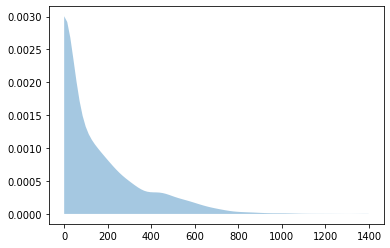

In [ ]:
from numpy.lib.function_base import average
from scipy.stats.kde import gaussian_kde
from numpy import linspace

degree = g.degree()
degree.extend([-x for x in degree]) # reflexive trick to avoid bias in 0.

kde = gaussian_kde(degree)
dist_space = linspace(min(g.degree()), max(degree), 100 )
plt.fill_between(dist_space,kde(dist_space), alpha = 0.4)
print("average degree:", round(average(g.degree()),2))

### 1.2 Scale free propery ?

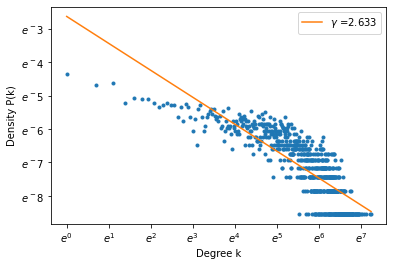

In [ ]:
import matplotlib.ticker as mtick
degree = np.array(g.degree())
dg = np.unique(degree, return_counts=True)
fig, ax = plt.subplots()
k = dg[0] 
pk = dg[1]/sum(dg[1])
lk = np.log(k[1:]) # exlude 0 degree for the log.
lpk = np.log(pk[1:])
m,b = np.polyfit(lk, lpk, 1) # a powerlaw is a linear fit in the log space pk ~ - lamba k
ax.plot(lk, lpk, '.')
ax.plot(lk, b + m*lk, label = r'$\gamma$ =' + str(-round(b,3)))
plt.xlabel("Degree k")
plt.ylabel("Density P(k)")
def ticks(y, pos):
    return r'$e^{:.0f}$'.format(y)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax.legend()

## 1.3 Relation to other metrics

In [ ]:
btw = g.betweenness()
dgr = g.degree()
clo = g.closeness()

## 1.3.1 Degree - Betweenness

(1.0, 117398.03704584464)

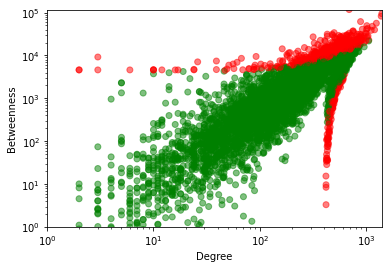

In [ ]:
#m,b = np.polyfit([np.log(i) for i in dgr if i != 0], [np.log(btw(i)) for i in dgr if i != 0], 1)
import matplotlib.colors as clrs

dgrpos = [np.log(dgr) for i, (dgr, btw) in enumerate(zip(dgr, btw)) if dgr > 0 and btw > 0]
btwpos = [np.log(btw) for i, (dgr, btw) in enumerate(zip(dgr, btw)) if dgr > 0 and btw > 0]
m,b = np.polyfit(dgrpos,btwpos,1)

# difference 
residuals = np.abs(np.array(btw) - np.exp(b) * (np.array(dgr) ** m))
residuals > np.quantile(residuals, q = 0.9) 

cmap = clrs.ListedColormap(['green', 'red'])

plt.scatter(dgr,btw, 
            c = residuals > np.quantile(residuals, q = 0.9), alpha = 0.5, cmap=cmap)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Betweenness")
plt.xlim(min(dgr)+1, max(dgr))
plt.ylim(min(btw)+1, max(btw))

# 2. Subgraph creation

2.1 Check connected component and subset.

In [ ]:
cc = g.clusters(mode="WEAK")
print("Number of connected component " +str(len(cc)))
cc = np.array(sorted(cc, key = len, reverse=True),dtype="object") # sorted components
print("largest component is " + str(len(cc[0])) + " nodes big")
print("second largest component is " + str(len(cc[1])) + " nodes big")

glc = g.subgraph(cc[0])

Number of connected component 542
largest component is 4599 nodes big
second largest component is 2 nodes big


## 2.1 Subset based on a metric

In [ ]:
highdegree = np.percentile(dgr, 95)
vertices_sub = g.vs.select([v for v, b in enumerate(dgr) if b <= highdegree])
gsub = g.subgraph(vertices_sub)

In [ ]:
cc = gsub.clusters(mode="WEAK")
print("Number of connected component " +str(len(cc)))
cc = np.array(sorted(cc, key = len, reverse=True),dtype="object") # sorted components
print("largest component is " + str(len(cc[0])) + " nodes big")
print("second largest component is " + str(len(cc[1])) + " nodes big")
print("Number of edges: ", gsub.ecount())

Number of connected component 546
largest component is 4337 nodes big
second largest component is 2 nodes big
Number of edges:  312078


# 3. Clustering

In [ ]:
def resclust(cluster): 
  print("Modularity:" + str(round(cluster.modularity,3)))
  print("Number of clusters: " + str(len(cluster)))
  print("Respective cluster sizes: " +  str(cluster.sizes()))

## 3.1 Leading Eigenvector

In [ ]:
leid = glc.community_leading_eigenvector() # definition: https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#clusters
# ref: MEJ Newman: Finding community structure in networks using the eigenvectors of matrices
resclust(leid)

Modularity:0.356
Number of clusters: 5
Respective cluster sizes: [992, 506, 1670, 1120, 311]


In [ ]:
lvn = glc.community_multilevel(weights=None)
resclust(lvn)

Modularity:0.399
Number of clusters: 8
Respective cluster sizes: [726, 1327, 691, 784, 490, 506, 72, 3]


In [ ]:
walktrap = glc.community_walktrap()
walktrap_cl = walktrap.as_clustering()
resclust(walktrap_cl)

Modularity:0.355
Number of clusters: 158
Respective cluster sizes: [164, 412, 1599, 432, 887, 1, 440, 2, 1, 1, 1, 1, 1, 1, 2, 1, 462, 1, 1, 1, 2, 1, 2, 2, 19, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 2, 1, 1, 1, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
#spin = glc.community_spinglass()
#resclust(spin)

KeyboardInterrupt: ignored

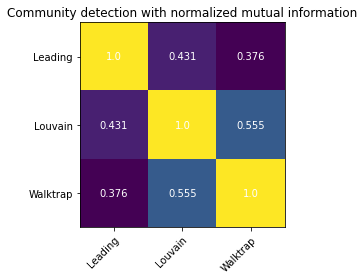

In [ ]:
#ig.compare_communities(lead, lvn, method='nmi')
# np.random.random(( 12 , 12 ))
methods = [leid, lvn, walktrap_cl]
mnames = ["Leading", "Louvain", "Walktrap"]
def plot_hmap_compt(methods, mnames):
  res = np.zeros(( len(methods) , len(methods) ))
  for ida, method_a in enumerate(methods):
    for idb, method_b in enumerate(methods):
      res[ida,idb] = ig.compare_communities(method_a, method_b, method='nmi')

  #plt.imshow( res , cmap = 'autumn' , interpolation = 'nearest' )
  #plt.title( "2-D Heat Map" )

  fig, ax = plt.subplots()

  im = ax.imshow(res)

  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(mnames)))
  ax.set_yticks(np.arange(len(mnames)))
  ax.set_xticklabels(mnames)
  ax.set_yticklabels(mnames)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(mnames)):
      for j in range(len(mnames)):
          text = ax.text(j, i, round(res[i, j], 3),
                        ha="center", va="center", color="w")
  ax.set_title("Community detection with normalized mutual information")
  fig.tight_layout()
  plt.show()

plot_hmap_compt(methods, mnames)

## Degeneracy problem

In [ ]:
nodes = glc.vcount()
meths = []
mod_list_lvn = []
perm_list = []
memb_list_lvn = []

for i in range(1,6):
  perm=np.random.permutation(nodes).tolist()
  perm_glc = glc.permute_vertices(perm)
  com = perm_glc.community_multilevel(weights = perm_glc.es["weight"])

  a = pd.DataFrame(data={'ID':perm_glc.vs()['id'],'cluster':com.membership})
  a = a.sort_values(by='ID')
  memb_list_lvn.append(a.loc[:,'cluster'].values)

  mod_list_lvn.append(com.modularity)
  meths.append(com)
  perm_list.append(perm)

mnames = ["a", "b", "c", "d", "e"]
for i in range(0,4):
  for j in range(i+1,5):
    rand = ig.compare_communities(memb_list_lvn[i], memb_list_lvn[j], 'rand')
    nmi =  ig.compare_communities(memb_list_lvn[i], memb_list_lvn[j], 'nmi')
    print('Comparing permutations {} and {}, nmi={}, rand = {}'.format(i,j,round(nmi,2),round(rand,2)))

Comparing permutations 0 and 1, nmi=0.75, rand = 0.91
Comparing permutations 0 and 2, nmi=0.84, rand = 0.96
Comparing permutations 0 and 3, nmi=0.86, rand = 0.96
Comparing permutations 0 and 4, nmi=0.79, rand = 0.93
Comparing permutations 1 and 2, nmi=0.72, rand = 0.91
Comparing permutations 1 and 3, nmi=0.76, rand = 0.91
Comparing permutations 1 and 4, nmi=0.77, rand = 0.92
Comparing permutations 2 and 3, nmi=0.82, rand = 0.95
Comparing permutations 2 and 4, nmi=0.77, rand = 0.92
Comparing permutations 3 and 4, nmi=0.79, rand = 0.93


## Preferential attachement

In [ ]:
!pip install gae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement gae (from versions: none)
ERROR: No matching distribution found for gae


In [ ]:
import networkx as nx
import random 

gnx = nx.Graph(glc.get_edgelist())
preds = nx.preferential_attachment(gnx)

prefs = list(nx.preferential_attachment(gnx)) # list with node a, node b and attachement score p

In [ ]:
prefs = sorted(prefs, key=lambda l: l[2], reverse=True) # high means close !

# make a ROC curve

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

edge_splitter_test = EdgeSplitter(gnx) 
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
gs_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.01, method="global"
)
edge_splitter_train = EdgeSplitter(gs_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.01, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)


** Sampled 4725 positive and 4725 negative edges. **
** Sampled 4677 positive and 4677 negative edges. **


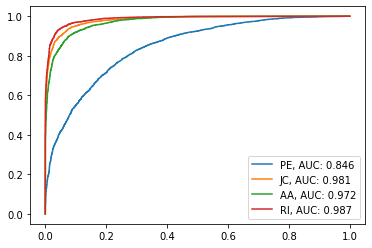

In [ ]:
methods = [nx.preferential_attachment, nx.jaccard_coefficient, nx.adamic_adar_index,
           nx.resource_allocation_index]
names = ["PE", "JC", "AA", "RI"]

for i, method in enumerate(methods):
  pred = list(method(gs_test, ebunch = examples_test))
  score = [s for (u,v,s) in pred]

  fpr, tpr, _ = roc_curve(labels_test, score)
  auc = roc_auc_score(labels_test, score)

  plt.plot(fpr,tpr, label = names[i] + ", AUC: " + str(round(auc,3)))
plt.legend()


## Graph Embedding 

In [ ]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

In [ ]:
gs = StellarGraph.from_networkx(gnx)
print(gs.info())

StellarGraph: Undirected multigraph
 Nodes: 4599, Edges: 472516

 Node types:
  default: [4599]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [472516]
        Weights: all 1 (default)
        Features: none


In [ ]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(gs) 

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
gs_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.05, method="global"
) # If ‘global’, then nodes are selected uniformly at random. 'local' for specific neighborhood.
# inspect variables on the rights, we see examples_test are pairs of nodes and labels_test are 1-0 if existing link or not.

print(gs_test.info())

** Sampled 23625 positive and 23625 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 4599, Edges: 448891

 Node types:
  default: [4599]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [448891]
        Weights: all 1 (default)
        Features: none


In [ ]:
# Do the same process to compute a training subset from within the test graph (note sampled links were removed before)
edge_splitter_train = EdgeSplitter(gs_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.05, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 22444 positive and 22444 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 4599, Edges: 426447

 Node types:
  default: [4599]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [426447]
        Weights: all 1 (default)
        Features: none


In [ ]:
from stellargraph.data import BiasedRandomWalk

def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 1.0 # Defines (unormalised) probability, 1/p, of returning to source node (big p = depth first style)
    q = 1.0 # Defines (unormalised) probability, 1/q, for moving away from source node (big q = breadth first style)
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)

In [ ]:
walk_length = 4
epochs = 2
batch_size = 400

In [ ]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras

def node2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = 32
    walk_number = 20

    print(f"Training Node2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a Node2Vec training generator, which generates batches of training pairs
    generator = Node2VecLinkGenerator(graph, batch_size)

    # Create the Node2Vec model
    node2vec = Node2Vec(dimension, generator=generator)

    # Build the model and expose input and output sockets of Node2Vec, for node pair inputs
    x_inp, x_out = node2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Node2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)

    # Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # Build the model to predict node representations from node ids with the learned Node2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec


def attri2vec_embedding(graph, name):

    # Set the embedding dimension and walk number:
    dimension = [64]
    walk_number = 4

    print(f"Training Attri2Vec for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define an Attri2Vec training generator, which generates batches of training pairs
    generator = Attri2VecLinkGenerator(graph, batch_size)

    # Create the Attri2Vec model
    attri2vec = Attri2Vec(
        layer_sizes=dimension, generator=generator, bias=False, normalize=None
    )

    # Build the model and expose input and output sockets of Attri2Vec, for node pair inputs
    x_inp, x_out = attri2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the Attri2Vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=1,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned Attri2Vec model parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Attri2VecNodeGenerator(graph, batch_size).flow(graph_node_list)
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

def graphsage_embedding(graph, name):

    # Set the embedding dimensions, the numbers of sampled neighboring nodes and walk number:
    dimensions = [64, 64]
    num_samples = [10, 5] #further away means less important so we sample less.
    walk_number = 1

    print(f"Training GraphSAGE for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GraphSAGE training generator, which generates batches of training pairs
    generator = GraphSAGELinkGenerator(graph, batch_size, num_samples)

    # Create the GraphSAGE model
    graphsage = GraphSAGE(
        layer_sizes=dimensions,
        generator=generator,
        bias=True,
        dropout=0.0,
        normalize="l2",
    )

    # Build the model and expose input and output sockets of GraphSAGE, for node pair inputs
    x_inp, x_out = graphsage.in_out_tensors()

    # Use the link_classification function to generate the output of the GraphSAGE model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned GraphSAGE model parameters
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = GraphSAGENodeGenerator(graph, batch_size, num_samples).flow(
        graph_node_list
    )
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding

def gcn_embedding(graph, name):

    # Set the embedding dimensions and walk number:
    dimensions = [64, 64]
    walk_number = 1

    print(f"Training GCN for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GCN training generator, which generates the full batch of training pairs
    generator = FullBatchLinkGenerator(graph, method="gcn")

    # Create the GCN model
    gcn = GCN(
        layer_sizes=dimensions,
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.3,
    )

    # Build the model and expose input and output sockets of GCN, for node pair inputs
    x_inp, x_out = gcn.in_out_tensors()

    # Use the dot product of node embeddings to make node pairs co-occurring in short random walks represented closely
    prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)
    prediction = keras.layers.Reshape((-1,))(prediction)

    # Stack the GCN encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    batches = unsupervised_samples.run(batch_size)
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        batch_iter = 1
        for batch in batches:
            samples = generator.flow(batch[0], targets=batch[1], use_ilocs=True)[0]
            [loss, accuracy] = model.train_on_batch(x=samples[0], y=samples[1])
            output = (
                f"{batch_iter}/{len(batches)} - loss:"
                + " {:6.4f}".format(loss)
                + " - binary_accuracy:"
                + " {:6.4f}".format(accuracy)
            )
            if batch_iter == len(batches):
                print(output)
            else:
                print(output, end="\r")
            batch_iter = batch_iter + 1

    # Get representations for all nodes in ``graph``
    embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
    node_embeddings = embedding_model.predict(
        generator.flow(list(zip(graph_node_list, graph_node_list)))
    )
    node_embeddings = node_embeddings[0][:, 0, :]

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

def link_prediction_classifier(max_iter=5000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])


In [ ]:
def operator_hadamard(u, v):
    return u * v

def operator_l1(u, v):
    return np.abs(u - v)

def operator_l2(u, v):
    return (u - v) ** 2

def operator_avg(u, v):
    return (u + v) / 2.0

def run_link_prediction(binary_operator, embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [ ]:
def train_and_evaluate(embedding, name):

    embedding_train = embedding(graph_train, "Train Graph")

    # Train the link classification model with the learned embedding
    results = [run_link_prediction(op, embedding_train) for op in binary_operators]
    best_result = max(results, key=lambda result: result["score"])
    print(
        f"\nBest result with '{name}' embeddings from '{best_result['binary_operator'].__name__}'"
    )
    display(
        pd.DataFrame(
            [(result["binary_operator"].__name__, result["score"]) for result in results],
            columns=("name", "ROC AUC"),
        ).set_index("name")
    )

    # Evaluate the best model using the test set
    test_score = evaluate_link_prediction_model(
        best_result["classifier"],
        examples_test,
        labels_test,
        embedding_train,
        best_result["binary_operator"],
    )

    # Calculate edge features for test data
    link_features = link_examples_to_features(
        examples_test, embedding_train, best_result["binary_operator"] 
    )

    # Learn a projection from 128 dimensions to 2
    #pca = PCA(n_components=2)
    #X_transformed = pca.fit_transform(link_features)

    m = umap.UMAP()
    X_transformed = m.fit_transform(link_features)

    # plot the 2-dimensional points
    plt.figure(figsize=(16, 12))
    plt.scatter(
      X_transformed[:, 0],
      X_transformed[:, 1],
      c=np.where(labels_test == 1, "b", "r"),
      alpha=0.5,
    )

    return test_score

Training Node2Vec for 'Train Graph':
link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
1378/1378 - 34s - loss: 0.7183 - binary_accuracy: 0.5054 - 34s/epoch - 25ms/step
Epoch 2/2
1378/1378 - 7s - loss: 0.7084 - binary_accuracy: 0.5117 - 7s/epoch - 5ms/step

Best result with 'Node2Vec' embeddings from 'operator_avg'


,ROC AUC
name,
operator_hadamard,0.500309
operator_l1,0.506068
operator_l2,0.511262
operator_avg,0.523734


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


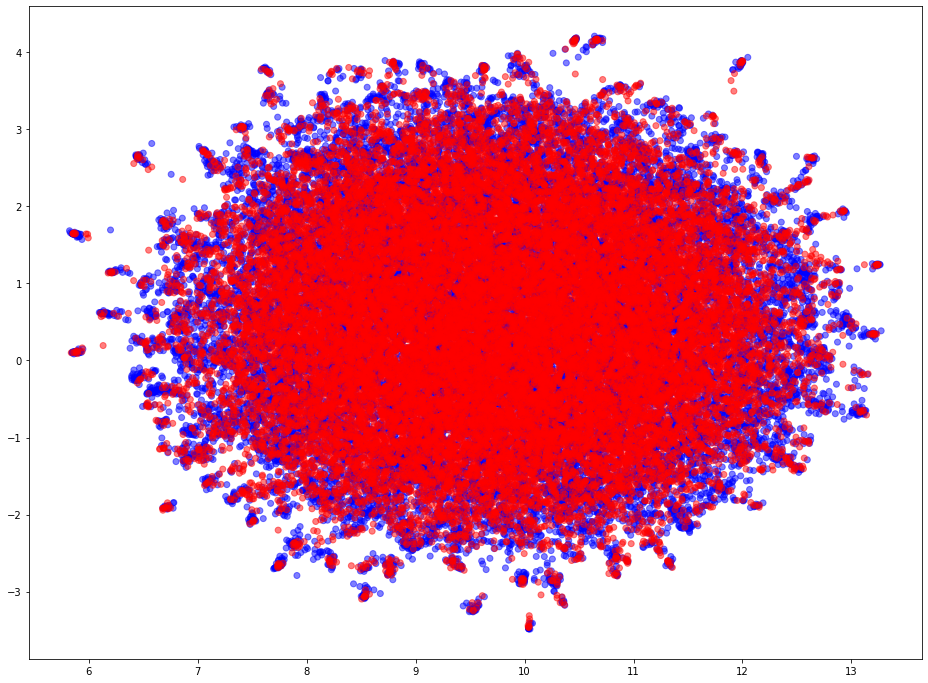

In [ ]:
node2vec_result = train_and_evaluate(node2vec_embedding, "Node2Vec")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.6 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=3e9a30d99f6e31623a496dea2701d18fe87f02bf13290a929e784957f78b77a2
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=3427ad11ec269d9bcf120f12d26c61d5df0a9180eec32e4140c90d4040ff2f7c
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
